In [1]:
! ls

inference_flowers.ipynb  models  Pretrained_on_flower.ipynb  pretr_meat.ipynb


In [2]:
# Only once 
# ! git clone https://gitlab.com/kvm108/models.git

/home/xoriant/PycharmProjects/meat_classification_try/meat_tf/slim


In [3]:
% cd models/research/slim

/home/xoriant/PycharmProjects/meat_classification_try/meat_tf/slim/models/research/slim


In [4]:
! ls

BUILD				preprocessing
datasets			pretrained_checkpoints
deployment			README.md
download_and_convert_data.py	results
eval_image_classifier.py	scripts
export_inference_graph.py	setup.py
export_inference_graph_test.py	slim_walkthrough.ipynb
flowers				train_image_classifier.py
__init__.py			WORKSPACE
nets


In [8]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
import tensorflow as tf
import time

from datasets import dataset_utils

# Main slim library
from tensorflow.contrib import slim

# Tesnsorflow libraries + slim helper 
import tensorflow as tf
from datasets import dataset_utils

In [35]:
# Step 1 : Convert images to tf record format
! python download_and_convert_data.py --dataset_name=custom --dataset_dir=../../../../images/all/

Dataset files already exist. Exiting without re-creating them.


In [36]:
! ls ../../../../images/all/

1				      custom_train_00004-of-00005.tfrecord
2				      custom_validation_00000-of-00005.tfrecord
3				      custom_validation_00001-of-00005.tfrecord
custom_train_00000-of-00005.tfrecord  custom_validation_00002-of-00005.tfrecord
custom_train_00001-of-00005.tfrecord  custom_validation_00003-of-00005.tfrecord
custom_train_00002-of-00005.tfrecord  custom_validation_00004-of-00005.tfrecord
custom_train_00003-of-00005.tfrecord  labels.txt


In [37]:
# Step 2 : checking images directory - Make sure *.tfrecord fiels present - both train + validation
# set path to prev cells path
images_data_dir = '../../../../images/all/'

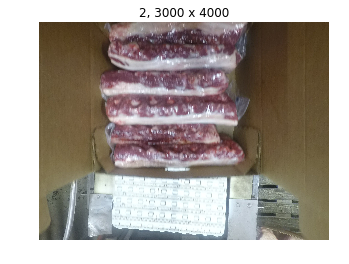

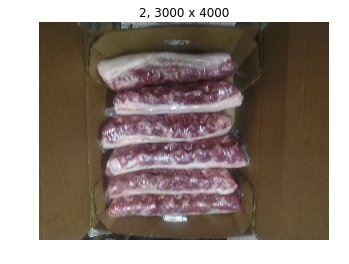

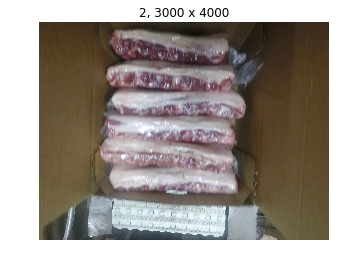

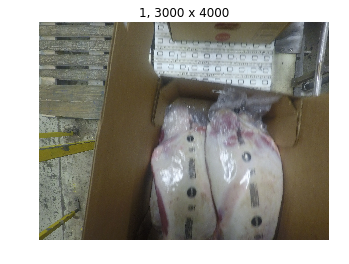

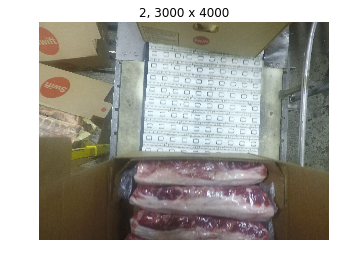

In [38]:
# Visualize the dataset : Try both 'validation' and 'train' in "custom.get_split(<HERE>, images_data_dir)"

from datasets import custom
import tensorflow as tf

from tensorflow.contrib import slim

#TODO : Change to tf.data

NO_OF_IMAGES = 5

with tf.Graph().as_default(): 
    dataset = custom.get_split('train', images_data_dir)
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32, common_queue_min=1)
    image, label = data_provider.get(['image', 'label'])
    
    with tf.Session() as sess:    
        with slim.queues.QueueRunners(sess):
            for i in range(NO_OF_IMAGES):
                np_image, np_label = sess.run([image, label])
                height, width, _ = np_image.shape
                class_name = name = dataset.labels_to_names[np_label]
                
                plt.figure()
                plt.imshow(np_image)
                plt.title('%s, %d x %d' % (name, height, width))
                plt.axis('off')
                plt.show()

In [39]:
# Download the Inception V3 checkpoint

from datasets import dataset_utils

url = 'http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz'

# "http://download.tensorflow.org/models/inception_v1_2016_08_28.tar.gz"
checkpoints_dir = 'checkpoints'

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)

dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

>> Downloading inception_v3_2016_08_28.tar.gz 100.0%
Successfully downloaded inception_v3_2016_08_28.tar.gz 100885009 bytes.


In [40]:
! ls checkpoints/

inception_v3_2016_08_28.tar.gz	inception_v3.ckpt


In [41]:
# Generic helper fucntion for Batching images

from preprocessing import inception_preprocessing
import tensorflow as tf

from tensorflow.contrib import slim


def load_batch(dataset, batch_size=32, height=299, width=299, is_training=False):
    """Loads a single batch of data.
    
    Args:
      dataset: The dataset to load.
      batch_size: The number of images in the batch.
      height: The size of each image after preprocessing.
      width: The size of each image after preprocessing.
      is_training: Whether or not we're currently training or evaluating.
    
    Returns:
      images: A Tensor of size [batch_size, height, width, 3], image samples that have been preprocessed.
      images_raw: A Tensor of size [batch_size, height, width, 3], image samples that can be used for visualization.
      labels: A Tensor of size [batch_size], whose values range between 0 and dataset.num_classes.
    """
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32,
        common_queue_min=8)
    image_raw, label = data_provider.get(['image', 'label'])
    
    # Preprocess image for usage by Inception.
    image = inception_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=1,
          capacity=2 * batch_size)
    
    return images, images_raw, labels

In [46]:
# step 

import os

from datasets import custom
from nets import inception
from preprocessing import inception_preprocessing

from tensorflow.contrib import slim
image_size = inception.inception_v3.default_image_size


def get_init_fn():
    """Returns a function run by the chief worker to warm-start the training."""
    checkpoint_exclude_scopes=["InceptionV3/Logits", "InceptionV3/AuxLogits"]
    
    exclusions = [scope.strip() for scope in checkpoint_exclude_scopes]

    variables_to_restore = []
    for var in slim.get_model_variables():
        for exclusion in exclusions:
            if var.op.name.startswith(exclusion):
                break
        else:
            variables_to_restore.append(var)

    return slim.assign_from_checkpoint_fn(
      os.path.join(checkpoints_dir, 'inception_v3.ckpt'),
      variables_to_restore)


train_dir = 'inceptionv3_meat_001/'

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = custom.get_split('train', images_data_dir)
    images, _, labels = load_batch(dataset, height=image_size, width=image_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        logits, _ = inception.inception_v3(images, num_classes=dataset.num_classes, is_training=True)
        
    # Specify the loss function:
    one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
    slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    total_loss = slim.losses.get_total_loss()

    # Create some summaries to visualize the training process:
    tf.summary.scalar('losses/total_loss', total_loss)
  
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    train_op = slim.learning.create_train_op(total_loss, optimizer)
    
    # Run the training:
    final_loss = slim.learning.train(
        train_op,
        logdir=train_dir,
        init_fn=get_init_fn(),
        number_of_steps=30)
    
#     TODO :  Figure out these metrics too + get rid of deprecated warnings
#     # Choose the metrics to compute:
#     prediction=tf.argmax(logits,1)
#     names_to_values, names_to_updates = slim.metrics.aggregate_metric_map({
#         "accuracy": slim.metrics.accuracy(predictions, labels),
#         "mse": slim.metrics.mean_squared_error(predictions, labels),
#     })
    
#     # Define the summaries to write:
#     for metric_name, metric_value in metrics_to_values.iteritems():
#         tf.summary.scalar(metric_name, metric_value)
                        
   
        
  
print('Finished training. Last batch loss %f' % final_loss)

INFO:tensorflow:Restoring parameters from inceptionv3_meat_001/model.ckpt-5
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting Session.
INFO:tensorflow:Saving checkpoint to path inceptionv3_meat_001/model.ckpt
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:Recording summary at step 5.
INFO:tensorflow:global step 6: loss = 0.4106 (61.547 sec/step)
INFO:tensorflow:global step 7: loss = 0.6460 (23.751 sec/step)
INFO:tensorflow:global step 8: loss = 0.2490 (23.659 sec/step)
INFO:tensorflow:global step 9: loss = 0.6391 (23.694 sec/step)
INFO:tensorflow:global step 10: loss = 0.4410 (23.690 sec/step)
INFO:tensorflow:global step 11: loss = 0.7025 (23.751 sec/step)
INFO:tensorflow:global step 12: loss = 0.3020 (23.785 sec/step)
INFO:tensorflow:global step 13: loss = 0.2990 (23.931 sec/step)
INFO:tensorflow:global step 14: loss = 0.3004 (24.033 sec/step)
INFO:tensorflow:global step 15: loss = 0.3407 (2

In [47]:
! python eval_image_classifier.py \
    --alsologtostderr \
    --checkpoint_path='inceptionv3_meat_001' \
    --dataset_dir=../../../../images/all/ \
    --dataset_name=custom \
    --dataset_split_name=validation \
    --model_name=inception_v3

Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Scale of 0 disables regularizer.
Instructions for updating:
Please switch to tf.metrics.accuracy. Note that the order of the labels and predictions arguments has been switched.
Instructions for updating:
Please use `streaming_sparse_recall_at_k`, and reshape labels from [batch_size] to [batch_size, 1].
Instructions for updating:
Please switch to tf.metrics.mean
INFO:tensorflow:Evaluating inceptionv3_meat_001/model.ckpt-30
INFO:tensorflow:Starting evaluation at 2018-10-09-07:50:02
INFO:tensorflow:Graph was finalized.
2018-10-09 13:20:02.536734: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
INFO:tensorflow:Restoring parameters from i